In [1]:
import os
import numpy as np
import cv2

from matplotlib import pyplot as plt
import matplotlib 

from time import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Carga conjunto de datos

Se proporciona la carpeta, a través de la variable folder, donde cada subcarpeta se corresponde con una clase. Cada clase contiene muestras en forma de imágenes jpg, todas del mismo tamaño

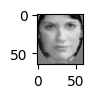

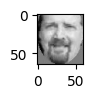

(1184, 3835)
(1184,)
Dataset info:
# samples: 1184
# features: 3835
# classes: 2
classes ['Female', 'Male']
samples per class 582, 602


In [4]:
#MODIFICAR INDICANDO RUTA EN TU EQUIPO TRAS DESCAGAR DATOS DEL CAMPUS
folder = "C:/Users/pablo/Desktop/23-24/VC/P6/DatabaseGender59x65" #Portátil

# Contador de número de clases del conjunto
nclasses = 0
# Contador de muestras por clase
nperclass = []
# Etiqueta de cada clase (nombre de la subcarpeta)
classlabels = []
# Inicializa estructuras de datos y sus correpondientes etiquetas
X = []
Y = []

# Valor de resolución por defecto de matplotlib
dpi = matplotlib.rcParams['figure.dpi']

# Asume que en la ruta indicada hay una subcarpeta por clase
for class_name in os.listdir(folder):
    # Cada subcarpeta implica una clase más
    nclasses += 1
    # Inicialmente esta clase no tiene muestras
    nsamples = 0

    # Compone la ruta
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Asume imágenes en formato jpg
        if file_name.endswith('.jpg'):
            # Lee la imagen
            image = cv2.imread (os.path.join(class_folder, file_name),)
            
            # Lugar para aplicar un RoI 
            # Ejemplo para la mitad superior
            # image = image[0:int(height/2),:]
            
            # Extrae tamaños
            height, width, depth = image.shape
            # Convierte  grises
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Añade a X, previa conversión en vector
            X.append(gray.reshape(height*width))
            # Añade etiqueta numérica de la muestra
            Y.append(nclasses-1)
            # Muestra primera imagen de la clase
            if nsamples == 0:
                figsize = width / float(dpi), height / float(dpi)

                plt.figure(figsize=figsize)
                plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
                plt.show()
  
            #Incrementa el número de muestras
            nsamples += 1
    nperclass.append(nsamples)
    classlabels.append(class_name)
    
#Convierte a numpy array X e Y
X = np.array(X,dtype='float32')
Y = np.array(Y,dtype='float64')

# Muestra datos del conjunto leído
# Depuración
print(X.shape)
print(Y.shape)
# Obtiene número de muestras y características
n_samples , n_features = X.shape
# Obtiene nombres de las clases
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

print("Dataset info:")
print("# samples: %d" % n_samples)
print("# features: %d" % n_features)
print("# classes: %d" % n_classes)
print("classes %s" % classlabels)
print("samples per class %s" % str(nperclass)[1:-1] )

# Diseña conjunto experimental 70/30

Divide los datos en conjunto de entrenamiento y test

In [5]:
# Split into a train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)

print("# samples in training set %d" % X_train.shape[0])
print("# samples in test set %d" % X_test.shape[0])

# samples in training set 828
# samples in test set 356


# Píxeles como descriptores y KNN con distancia euclídea para clasificación

In [6]:
#KNN utilizando píxeles 
print("KNN classifier based on pixels\nTraining...")
t0 = time()
# k = 5 
model_px = KNeighborsClassifier(n_neighbors = 5) 
  
# fdtraining of model 
model_px.fit(X_train, y_train) 
print("done in %0.3fs" % (time() - t0))

print("Predicting...")
t0 = time()
y_pred=model_px.predict(X_test)

print("done in %0.3fs" % (time() - t0))

print("Classification results:")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Precision:  %0.3f, Recall:  %0.3f" % ( precision_score(y_test, y_pred),recall_score(y_test, y_pred) )) 
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

KNN classifier based on pixels
Training...
done in 0.009s
Predicting...
done in 1.989s
Classification results:
              precision    recall  f1-score   support

      Female       0.73      0.75      0.74       185
        Male       0.72      0.70      0.71       171

    accuracy                           0.72       356
   macro avg       0.72      0.72      0.72       356
weighted avg       0.72      0.72      0.72       356

Precision:  0.717, Recall:  0.696
Confusion matrix
[[138  47]
 [ 52 119]]


# Cálculo de PCA (150 componentes) 

PCA computation using 150 components from 828 faces...
done in 1.780s
Projecting training and test on the eigenfaces orthonormal basis...
done in 0.309s


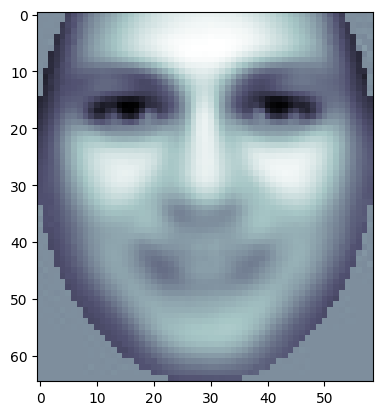

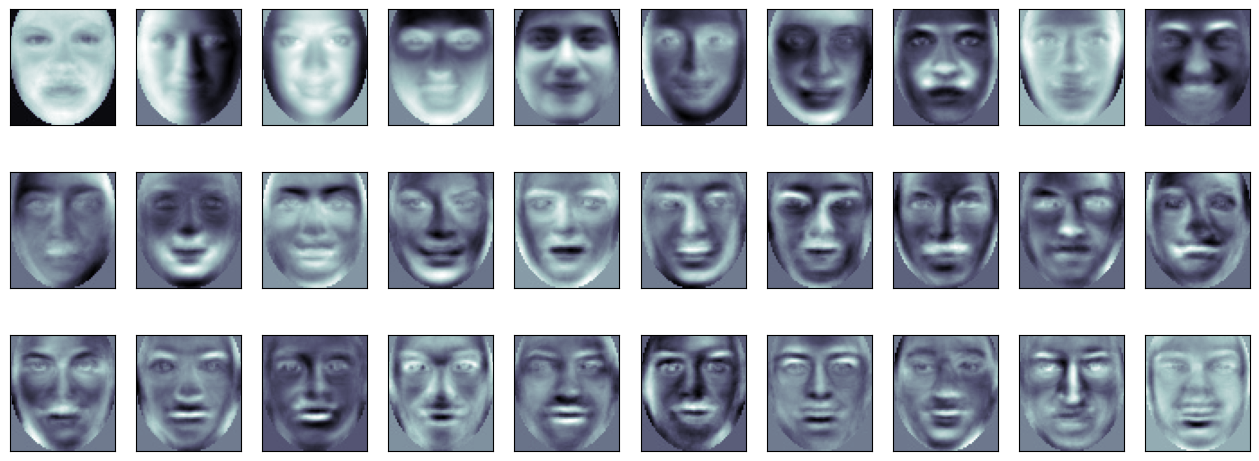

In [7]:
# Compute PCA on the training subset for n_comp components
n_comp = 150
print("PCA computation using %d components from %d faces..."
      % (n_comp, X_train.shape[0]))
t0 = time()
pca_n = PCA(n_components=n_comp, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces_n = pca_n.components_.reshape((n_comp, height, width))

print("Projecting training and test on the eigenfaces orthonormal basis...")
t0 = time()
X_train_pca_n = pca_n.transform(X_train)
X_test_pca_n = pca_n.transform(X_test)
print("done in %0.3fs" % (time() - t0))

# Cara media
plt.imshow(pca_n.mean_.reshape(height,width),            cmap=plt.cm.bone)

fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca_n.components_[i].reshape(height,width),
              cmap=plt.cm.bone)

# PCA (150 componentes) como descriptores y KNN con distancia euclídea para clasificación

In [8]:
#KNN for k neighbors
k = 5
print("KNN (k=%d) classifier based on %d PCA components..." % (k, n_comp) ) 
t0 = time()
model_pca_n = KNeighborsClassifier(n_neighbors = k) 
  
# fdtraining of model 
model_pca_n.fit(X_train_pca_n, y_train) 
print("done in %0.3fs" % (time() - t0))

print("Predicting...")
t0 = time()
y_pred=model_pca_n.predict(X_test_pca_n)

print("done in %0.3fs" % (time() - t0))

print("\nMetrics")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Precision:  %0.3f, Recall:  %0.3f" % ( precision_score(y_test, y_pred),recall_score(y_test, y_pred) )) 
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

KNN (k=5) classifier based on 150 PCA components...
done in 0.004s
Predicting...
done in 0.060s

Metrics
              precision    recall  f1-score   support

      Female       0.73      0.69      0.71       185
        Male       0.68      0.73      0.70       171

    accuracy                           0.71       356
   macro avg       0.71      0.71      0.71       356
weighted avg       0.71      0.71      0.71       356

Precision:  0.681, Recall:  0.725
Confusion matrix
[[127  58]
 [ 47 124]]


# PCA (150 componentes) como descriptores y SVM para clasificación

In [13]:
# Train a SVM classifier
print("SVM training...")
t0 = time()
parameters = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
# Grid search across parameter range
clf_pca_n = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), parameters, cv=5
)
clf_pca_n = clf_pca_n.fit(X_train_pca_n, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_pca_n.best_estimator_)


print("Predicting")
t0 = time()
y_pred = clf_pca_n.predict(X_test_pca_n)
print("done in %0.3fs" % (time() - t0))

print("\nMetrics")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Precision:  %0.3f, Recall:  %0.3f" % ( precision_score(y_test, y_pred),recall_score(y_test, y_pred) )) 
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

SVM training...
done in 50.977s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 0.233s

Metrics
              precision    recall  f1-score   support

      Female       0.92      0.86      0.89       185
        Male       0.86      0.92      0.89       171

    accuracy                           0.89       356
   macro avg       0.89      0.89      0.89       356
weighted avg       0.90      0.89      0.89       356

Precision:  0.863, Recall:  0.924
Confusion matrix
[[160  25]
 [ 13 158]]


In [ ]:
Tras la ejecución, para todas las variantes se muestran métricas y matriz de confusión. ¿Qué esquema consideras que es mejor?

Para el dataset que hemos utilizado este es el mejor

# Cálculo de PCA (95% de la varianza)

In [10]:
# ompute PCA on the training subset for n_comp components
print("PCA computation for .95 of the variance from %d faces..."
      % (X_train.shape[0]))
t0 = time()
pca_95 = PCA(.85).fit(X_train)
print("done in %0.3fs" % (time() - t0))
print("%d components selected" % (pca_95.n_components_ ))

eigenfaces_95 = pca_95.components_.reshape((pca_95.n_components_ , height, width))

print("Projecting training and test on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca_95 = pca_95.transform(X_train)
X_test_pca_95 = pca_95.transform(X_test)
print("done in %0.3fs" % (time() - t0))

PCA computation for .95 of the variance from 828 faces...
done in 5.533s
40 components selected
Projecting training and test on the eigenfaces orthonormal basis
done in 0.110s


# PCA (95% varianza) como descriptores y KNN con distancia euclídea para clasificación

In [11]:
#KNN for k neighbors
k = 5
print("KNN (k=%d) classifier based on %d PCA components..." % (k, pca_95.n_components_) ) 
t0 = time()
model_pca_95 = KNeighborsClassifier(n_neighbors = k) 
  
# fdtraining of model 
model_pca_95.fit(X_train_pca_95, y_train) 
print("done in %0.3fs" % (time() - t0))

print("Predicting...")
t0 = time()
y_pred=model_pca_95.predict(X_test_pca_95)

print("done in %0.3fs" % (time() - t0))

print("\nMetrics")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Precision:  %0.3f, Recall:  %0.3f" % ( precision_score(y_test, y_pred),recall_score(y_test, y_pred) )) 
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

KNN (k=5) classifier based on 40 PCA components...
done in 0.003s
Predicting...
done in 0.031s

Metrics
              precision    recall  f1-score   support

      Female       0.75      0.70      0.72       185
        Male       0.70      0.74      0.72       171

    accuracy                           0.72       356
   macro avg       0.72      0.72      0.72       356
weighted avg       0.72      0.72      0.72       356

Precision:  0.698, Recall:  0.743
Confusion matrix
[[130  55]
 [ 44 127]]


# PCA (95% varianza) como descriptores y SVM para clasificación 

In [12]:
# Train a SVM classifier
# Data normalization according to training data before training
print("Normalization...")
scaler = MinMaxScaler()
train_X = scaler.fit_transform(X_train_pca_95)
test_X = scaler.transform(X_test_pca_95)

print("SVM training...")
t0 = time()
parameters = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}
# Grid serach across parameter range
clf_pca_95 = GridSearchCV(
    SVC(kernel='rbf', class_weight='balanced'), parameters, cv=5
)
clf_pca_95 = clf_pca_95.fit(train_X, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_pca_95.best_estimator_)


print("Predicting")
t0 = time()
y_pred = clf_pca_95.predict(test_X)
print("done in %0.3fs" % (time() - t0))

print("\nMetrics")
print(classification_report(y_test, y_pred, target_names=class_names))
print("Precision:  %0.3f, Recall:  %0.3f" % ( precision_score(y_test, y_pred),recall_score(y_test, y_pred) )) 
print("Confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Normalization...
SVM training...
done in 51.907s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.01)
Predicting
done in 0.062s

Metrics
              precision    recall  f1-score   support

      Female       0.87      0.87      0.87       185
        Male       0.86      0.86      0.86       171

    accuracy                           0.87       356
   macro avg       0.86      0.86      0.86       356
weighted avg       0.87      0.87      0.87       356

Precision:  0.860, Recall:  0.860
Confusion matrix
[[161  24]
 [ 24 147]]
